In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def show(imgs):
    grid = vutils.make_grid(imgs.cpu())
    plt.imshow(grid.permute(1, 2, 0))

# GAN

In [ ]:
img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/fashion-mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion-mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(200):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )


Extracting ./data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw




Extracting ./data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw




Extracting ./data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw




Extracting ./data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 628/938] [D loss: 0.518133] [G loss: 1.166919]
[Epoch 194/200] [Batch 629/938] [D loss: 0.465780] [G loss: 1.231575]
[Epoch 194/200] [Batch 630/938] [D loss: 0.561982] [G loss: 1.230778]
[Epoch 194/200] [Batch 631/938] [D loss: 0.566447] [G loss: 1.148303]
[Epoch 194/200] [Batch 632/938] [D loss: 0.575445] [G loss: 0.910071]
[Epoch 194/200] [Batch 633/938] [D loss: 0.539314] [G loss: 1.177160]
[Epoch 194/200] [Batch 634/938] [D loss: 0.570024] [G loss: 1.146083]
[Epoch 194/200] [Batch 635/938] [D loss: 0.624547] [G loss: 1.119300]
[Epoch 194/200] [Batch 636/938] [D loss: 0.530331] [G loss: 1.133577]
[Epoch 194/200] [Batch 637/938] [D loss: 0.542322] [G loss: 1.210929]
[Epoch 194/200] [Batch 638/938] [D loss: 0.548641] [G loss: 1.029513]
[Epoch 194/200] [Batch 639/938] [D loss: 0.561949] [G loss: 1.245686]
[Epoch 194/200] [Batch 640/938] [D loss: 0.502076] [G loss: 0.943217]
[Epoch 194/200] [Batch 641/938] [D loss

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/fashion-mnist-generator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/fashion-mnist-discriminator.pth')

# GAN with Noise

In [ ]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.05, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [ ]:
img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False

class GeneratorN(nn.Module):
    def __init__(self):
        super(GeneratorN, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class DiscriminatorN(nn.Module):
    def __init__(self, std=0.1, std_decay_rate=0):
        super(DiscriminatorN, self).__init__()
        self.std = std
        self.std_decay_rate = std_decay_rate

        self.model = nn.Sequential(
            GaussianNoise(self.std, self.std_decay_rate),
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            GaussianNoise(self.std, self.std_decay_rate),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            GaussianNoise(self.std, self.std_decay_rate),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = GeneratorN()
discriminator = DiscriminatorN()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/fashion-mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion-mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(200):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )

Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 628/938] [D loss: 0.642824] [G loss: 1.099858]
[Epoch 194/200] [Batch 629/938] [D loss: 0.615781] [G loss: 0.824570]
[Epoch 194/200] [Batch 630/938] [D loss: 0.570822] [G loss: 1.189412]
[Epoch 194/200] [Batch 631/938] [D loss: 0.575245] [G loss: 0.989118]
[Epoch 194/200] [Batch 632/938] [D loss: 0.581102] [G loss: 1.038881]
[Epoch 194/200] [Batch 633/938] [D loss: 0.584376] [G loss: 1.009154]
[Epoch 194/200] [Batch 634/938] [D loss: 0.547980] [G loss: 0.976134]
[Epoch 194/200] [Batch 635/938] [D loss: 0.591989] [G loss: 1.026234]
[Epoch 194/200] [Batch 636/938] [D loss: 0.583698] [G loss: 1.096608]
[Epoch 194/200] [Batch 637/938] [D loss: 0.618400] [G loss: 0.825624]
[Epoch 194/200] [Batch 638/938] [D loss: 0.616438] [G loss: 0.874268]
[Epoch 194/200] [Batch 639/938] [D loss: 0.593007] [G loss: 1.113600]
[Epoch 194/200] [Batch 640/938] [D loss: 0.628402] [G loss: 0.993970]
[Epoch 194/200] [Batch 641/938] [D loss

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


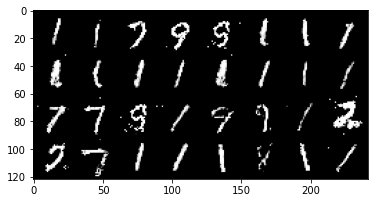

In [ ]:
show(gen_imgs)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-ngenerator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-ndiscriminator.pth')

# CGAN

In [ ]:
class CGenerator(nn.Module):
    def __init__(self):
        super(CGenerator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100 + 10, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod((1, 28, 28)))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *(1, 28, 28))
        return img


class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()

        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(10 + int(np.prod((1, 28, 28))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
cuda = True if torch.cuda.is_available() else False

In [ ]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = CGenerator()
discriminator = CDiscriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [ ]:
for epoch in range(100):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
        gen_labels = Variable(LongTensor(np.random.randint(0, 10, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )

Streaming output truncated to the last 5000 lines.
[Epoch 94/200] [Batch 628/938] [D loss: 0.255712] [G loss: 0.276666]
[Epoch 94/200] [Batch 629/938] [D loss: 0.244675] [G loss: 0.256369]
[Epoch 94/200] [Batch 630/938] [D loss: 0.251282] [G loss: 0.264487]
[Epoch 94/200] [Batch 631/938] [D loss: 0.254645] [G loss: 0.254775]
[Epoch 94/200] [Batch 632/938] [D loss: 0.252010] [G loss: 0.239296]
[Epoch 94/200] [Batch 633/938] [D loss: 0.240175] [G loss: 0.264433]
[Epoch 94/200] [Batch 634/938] [D loss: 0.239914] [G loss: 0.290172]
[Epoch 94/200] [Batch 635/938] [D loss: 0.250478] [G loss: 0.275930]
[Epoch 94/200] [Batch 636/938] [D loss: 0.241898] [G loss: 0.262876]
[Epoch 94/200] [Batch 637/938] [D loss: 0.244349] [G loss: 0.254754]
[Epoch 94/200] [Batch 638/938] [D loss: 0.245142] [G loss: 0.231997]
[Epoch 94/200] [Batch 639/938] [D loss: 0.254367] [G loss: 0.236713]
[Epoch 94/200] [Batch 640/938] [D loss: 0.246590] [G loss: 0.242585]
[Epoch 94/200] [Batch 641/938] [D loss: 0.236027] [G

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


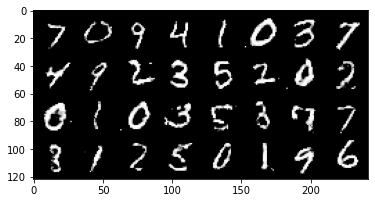

In [ ]:
show(gen_imgs)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-cdiscriminator.pth')

# Explainable

In [ ]:
device = torch.device("cuda:0")

In [ ]:
netG = Generator()
netCG = CGenerator()

In [ ]:
netG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/fashion-mnist-generator.pth'))
netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/fashion-mnist-cgenerator.pth'))

<All keys matched successfully>

In [ ]:
netD = Discriminator()
# netCD = CDiscriminator()

In [ ]:
netD.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/fashion-mnist-discriminator.pth'))
# netCD.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cdiscriminator.pth'))

<All keys matched successfully>

In [ ]:
netD.to(device)
# netCD.to(device)
netG.to(device)
netCG.to(device)

CGenerator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
!pip install captum

     |████████████████████████████████| 1.4 MB 4.3 MB/s 


In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import DeepLiftShap

## Normal GAN

In [ ]:
os.makedirs("./data/fashion-mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion-mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=100,
    shuffle=False,
)


Extracting ./data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw




Extracting ./data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw




Extracting ./data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw




Extracting ./data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashion-mnist/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Deeplift SHAP

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = netG(z)

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
dl = DeepLiftShap(netD)

9


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


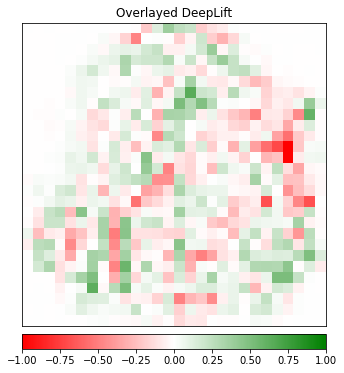

0


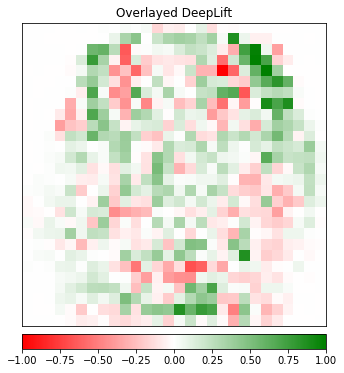

3


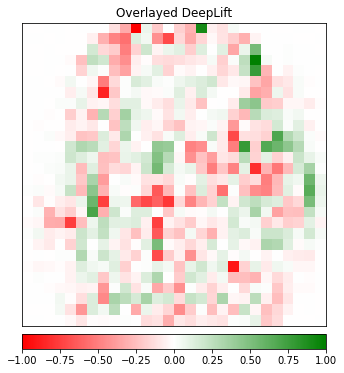

2


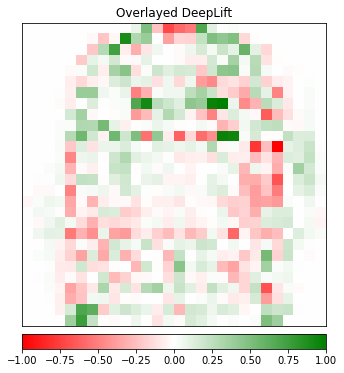

7


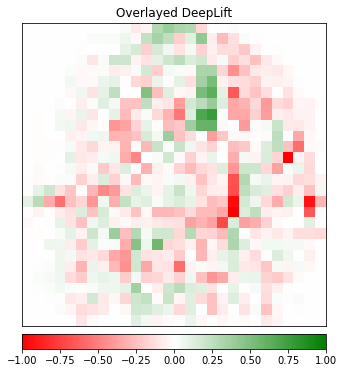

5


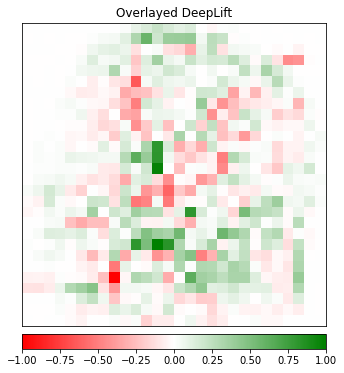

1


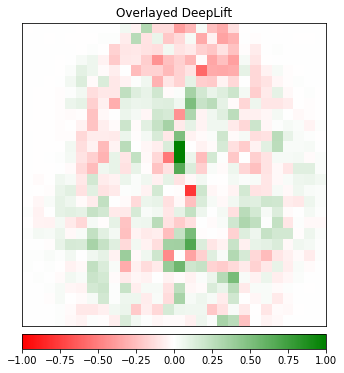

6


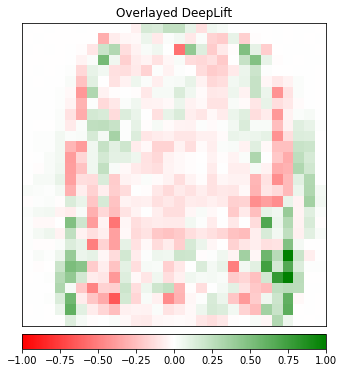

4


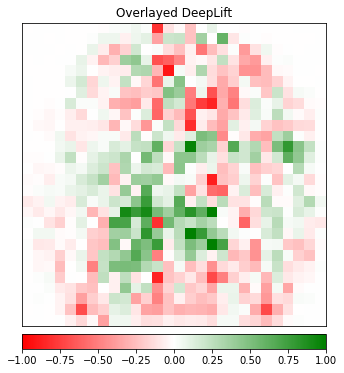

8


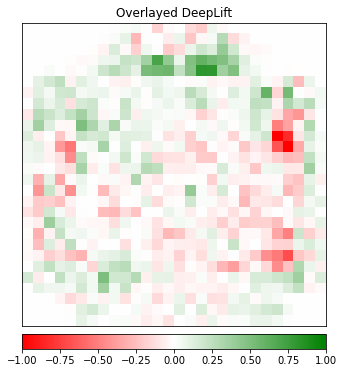

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    attr_dl = dl.attribute(input.to(device), baselines=fakes, target=None)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="Overlayed DeepLift")

## GAN with noise

In [ ]:
os.makedirs("./data/fashion-mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion-mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=100,
    shuffle=False,
)

In [ ]:
netGN = GeneratorN()
netDN = DiscriminatorN()

In [ ]:
netGN.to(device)
netDN.to(device)

DiscriminatorN(
  (model): Sequential(
    (0): GaussianNoise()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): GaussianNoise()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): GaussianNoise()
    (7): Linear(in_features=256, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [ ]:
netGN.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/fashion-mnist-ngenerator.pth'))
netDN.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/fashion-mnist-ndiscriminator.pth'))

<All keys matched successfully>

### Deeplift SHAP

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = netGN(z)

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
dl = DeepLiftShap(netDN)

9


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


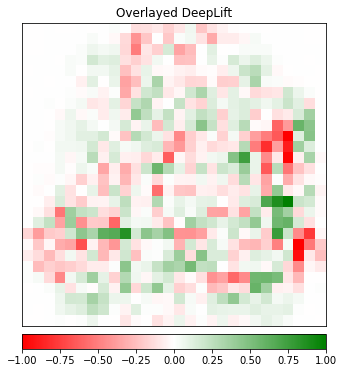

0


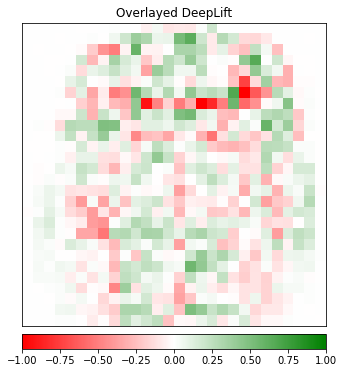

3


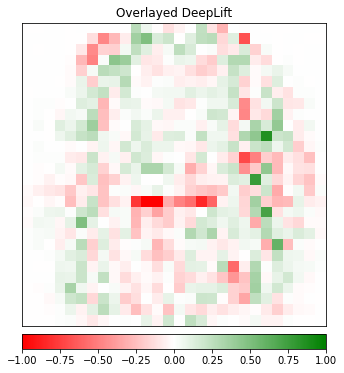

2


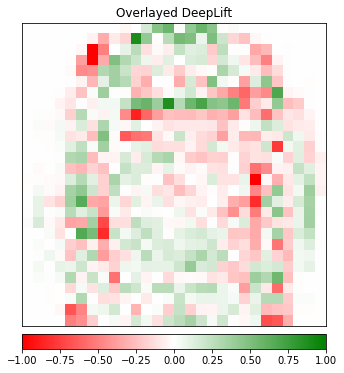

7


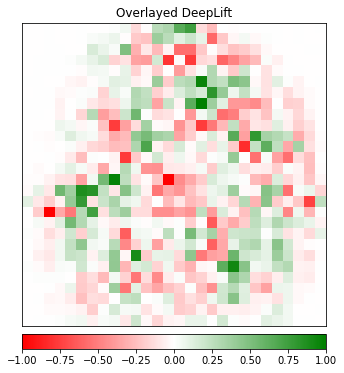

5


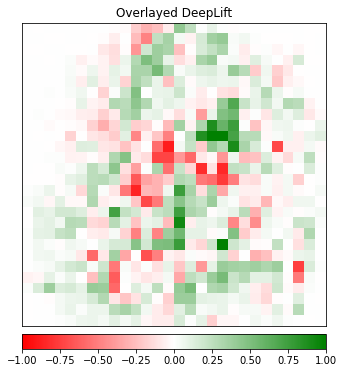

1


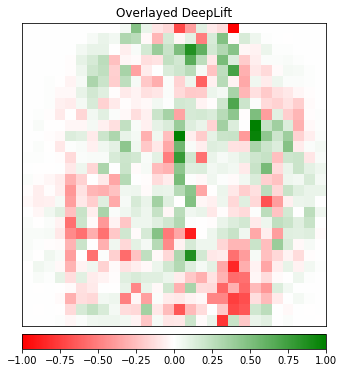

6


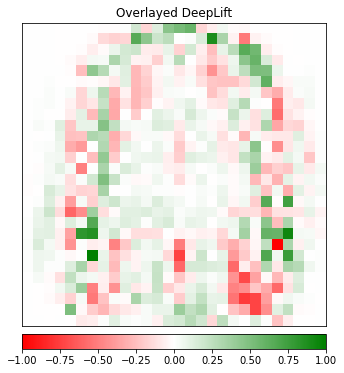

4


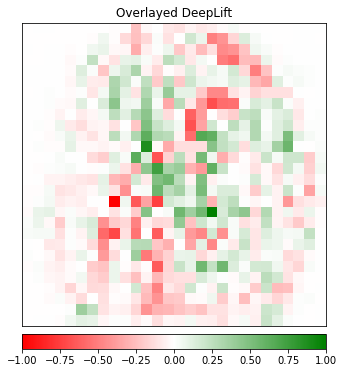

8


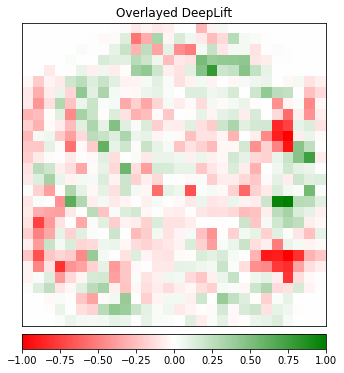

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    attr_dl = dl.attribute(input.to(device), baselines=fakes, target=None)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="Overlayed DeepLift")

## CGAN

In [ ]:
os.makedirs("./data/fashion-mnist", exist_ok=True)
cdataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/fashion-mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=100,
    shuffle=False,
)

In [ ]:
class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()

        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(10 + int(np.prod((1, 28, 28))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, d_in):
        # Concatenate label embedding and image to produce input
        validity = self.model(d_in)
        return validity

In [ ]:
netCD = CDiscriminator()

In [ ]:
netCD

CDiscriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
netCD.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/fashion-mnist-cdiscriminator.pth'))

<All keys matched successfully>

In [ ]:
netCD.to(device)

CDiscriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### Deeplift SHAP

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
z

tensor([[ 0.1147, -0.3115,  1.3906,  ...,  0.4363,  0.1827, -0.4213],
        [-0.2983, -2.4002,  0.2889,  ...,  0.2260,  0.5783, -1.1220],
        [-0.2842,  0.6323, -0.6847,  ..., -1.2463,  0.2291, -0.5698],
        ...,
        [ 0.5769,  0.9999, -1.4256,  ...,  0.2776,  0.9121, -1.5095],
        [ 1.2694, -1.1581, -1.3407,  ..., -0.1228, -0.2016, -0.0898],
        [ 2.2231, -0.1344,  0.0346,  ..., -1.7662, -1.7228,  0.4285]],
       device='cuda:0')

In [ ]:
fake_labels = torch.full((250,), 0)
for i in range(1, 10):
    fake_labels = torch.cat((fake_labels, torch.full((250,), i)))

In [ ]:
fake_labels = fake_labels.to(device)

In [ ]:
fakes = netCG(z, fake_labels)

In [ ]:
test = fakes[0: 25]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


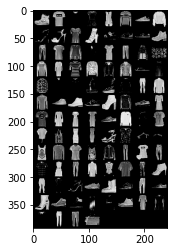

In [ ]:
show(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


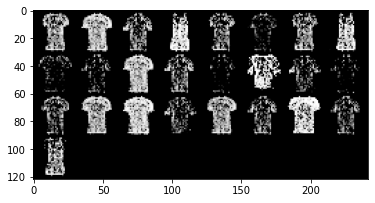

In [ ]:
show(test)

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
fake_labels.shape

torch.Size([2500])

In [ ]:
for idx, (imgs, labels) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
        fake_labels = torch.cat((fake_labels, labels.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
fake_labels.shape

torch.Size([5000])

In [ ]:
dl = DeepLiftShap(netCD)

In [ ]:
torch.LongTensor([5])

tensor([5])

In [ ]:
combined = torch.cat((fakes.view(fakes.size(0), -1), netCD.label_embedding(fake_labels)), -1)

In [ ]:
combined.shape

torch.Size([5000, 794])

In [ ]:
combined.device

device(type='cuda', index=0)

9


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


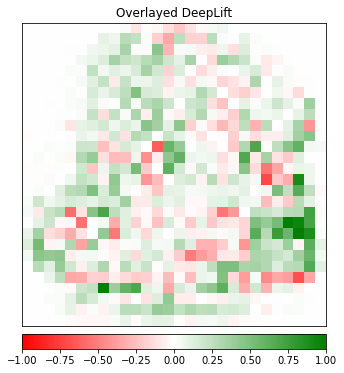

0


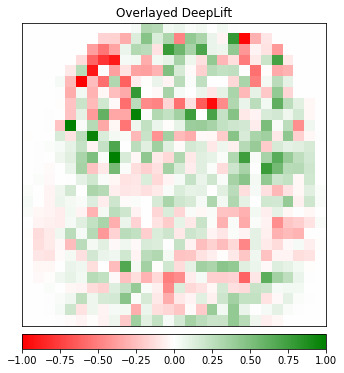

3


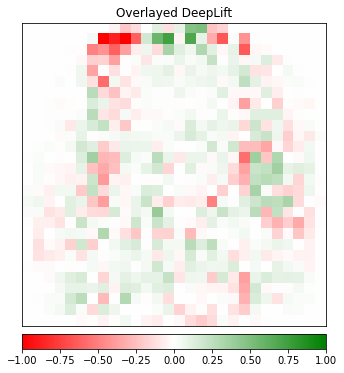

2


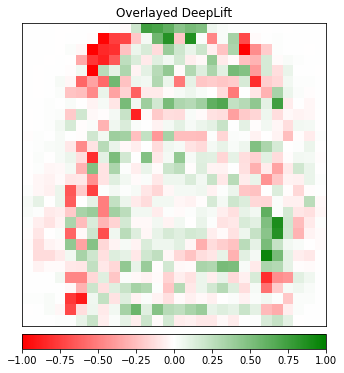

7


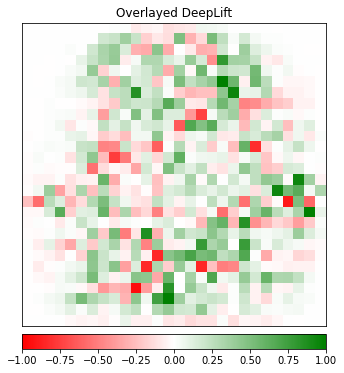

5


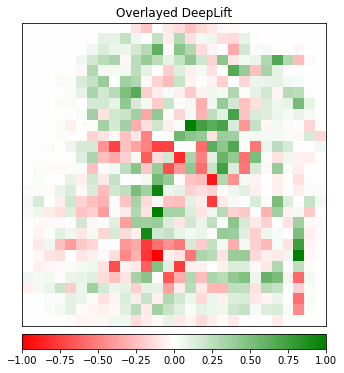

1


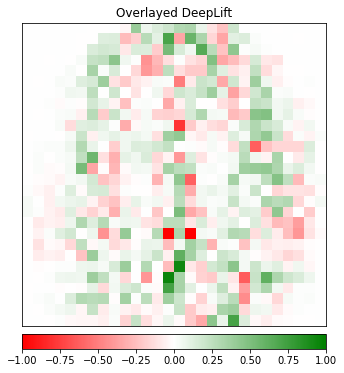

6


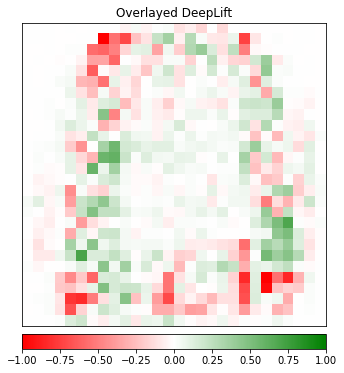

4


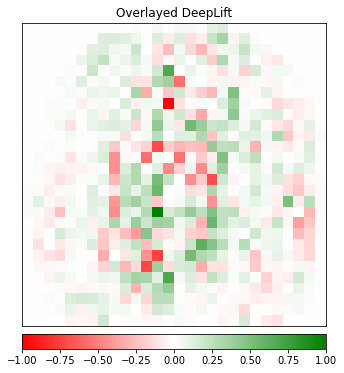

8


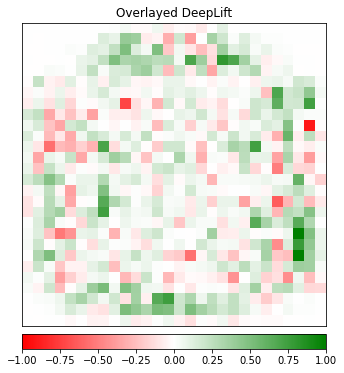

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    label = torch.LongTensor([real_labels[idx]])
    label = label.to(device)
    img = img.to(device)
    d_in = torch.cat((img.view(img.size(0), -1), netCD.label_embedding(label)), -1)
    attr_dl = dl.attribute(d_in, baselines=combined, target=None)
    attr_dl = attr_dl[0, :784].cpu().detach().numpy().reshape(28, 28, 1)
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")